In [6]:
import sys
import numpy as np
import pandas as pd
import yaml
from pathlib import Path
# Allow imports from project scripts
#sys.path.append(str(Path.cwd().parents[0]))
project_root = Path.cwd().parents[0]
sys.path.append(str(project_root))
from scripts.paths import PROJECT_ROOT, load_config

config = load_config()
sim_cfg = config["simulation"]
paths = config["paths"]

output_path = PROJECT_ROOT / paths["output_data"]
sim_cfg

{'Z': 50,
 'A': 132,
 'n_events': 100000,
 'reaction_prob': 0.1,
 'layers': 5,
 'b_min': 0.6,
 'b_max': 0.7,
 'eloss_scaling': 0.1,
 'layer_thickness': [0.4997, 0.5123, 0.5211, 0.5263, 0.5337]}

In [7]:
c = 299792458  # speed of light in m/s
u = 931.5 # atomic mass unit 

def kinetic_energy(A, beta):
    gamma = 1 / np.sqrt(1 - beta**2)
    return (gamma - 1) * A * u

def beta(A, E_kin):
    gamma = E_kin / (A * u) + 1
    beta = np.sqrt(1 - 1 / gamma**2)
    return beta


In [12]:
def simulate_event(Z, A, b_min, b_max, layers, reaction_prob, layer_thickness, eloss_scaling = 1.0):
    """
    Simulate one particle through a layered detector with potential reaction.
    """
    b_in = np.random.uniform(b_min, b_max)
    b = b_in
    current_Z = Z
    E_losses = []
    reacted = False
    reaction_layer = 0  # 0 means no reaction
    reaction_depth = None
    
    for i in range(layers):
        thickness = layer_thickness[i]
        E_kin = kinetic_energy(A,b)
        # Simple stopping power model: dE/dx ~ Z^2 / b^2
        stopping_power = (current_Z ** 2) / (b ** 2) * eloss_scaling
        delta_E = stopping_power * thickness
        E_losses.append(delta_E)
        # print(current_Z,b,E_kin/A,delta_E)

        # Placeholder for future depth-resolved dE:
        # If reaction occurs here, to be adjusted later.
        # Reaction chance
        reaction_chance = reaction_prob * (thickness / np.mean(layer_thickness))
        if not reacted and np.random.rand() < reaction_chance:
            reacted = True
            reaction_layer = i + 1
            current_Z = max(current_Z - 1, 1)
            reaction_depth = np.random.uniform(0, thickness)

            # Future upgrade:
            # - split delta_E into dE_before + dE_after using reaction_depth
            # - update beta after first partial step
            
        # Update velocity
        E_kin = max(E_kin - delta_E, 1e-6)  # Prevent negative kinetic energy
        b = beta(A, E_kin)

    return {
        'b_in': b_in,
        'b_out': b,
        'reaction_layer': reaction_layer,
        'reaction_depth': reaction_depth,
        **{f'dE_{i+1}': E_losses[i] for i in range(layers)}
    }

In [13]:
from tqdm.notebook import tqdm  # For nice Jupyter-style progress bars
def generate_dataset(n, **kwargs):
    """
    Generate multiple events using simulate_event.
    """
    return pd.DataFrame([
        simulate_event(**kwargs) for _ in tqdm(range(n), desc="Simulating events")
    ])

In [14]:
# Generate the dataset
df = generate_dataset(
    n=sim_cfg["n_events"],
    Z=sim_cfg["Z"],
    A=sim_cfg["A"],
    b_min=sim_cfg["b_min"],
    b_max=sim_cfg["b_max"],
    layers=sim_cfg["layers"],
    eloss_scaling=sim_cfg["eloss_scaling"],
    reaction_prob=sim_cfg["reaction_prob"],
    layer_thickness=sim_cfg["layer_thickness"]
)

# Show a sample
df.head()
df.to_csv(output_path, index=False)
print(f"Saved dataset to {output_path}")

Simulating events:   0%|          | 0/100000 [00:00<?, ?it/s]

Saved dataset to /home/wimmer/projects/LISA/MLISA/data/raw/simulated_data.csv


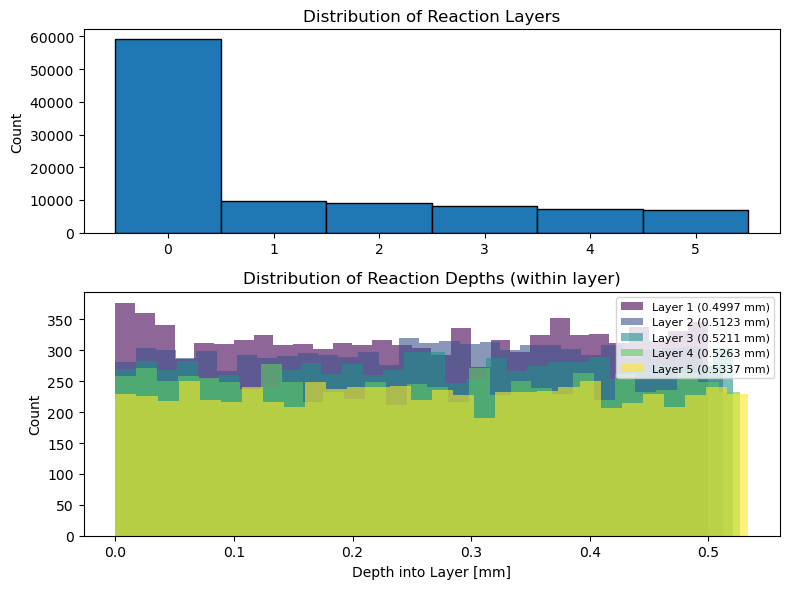

In [15]:
import matplotlib.pyplot as plt

layers = sim_cfg["layers"]
thicknesses = sim_cfg["layer_thickness"]
reaction_layers = df["reaction_layer"]
reaction_depths = df["reaction_depth"]

# Filter for only reacted events
reacted_df = df[df["reaction_layer"] > 0]

# --- FIXED: height_ratios must go in gridspec_kw
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8, 6),
    sharex=False,
    gridspec_kw={"height_ratios": [1, 1.2]}
)

# Panel 1: Reaction layer histogram
ax1.hist(reaction_layers, bins=np.arange(-0.5, layers + 1.5), edgecolor='black')
ax1.set_title("Distribution of Reaction Layers")
ax1.set_ylabel("Count")
ax1.set_xticks(range(layers + 1))

# Panel 2: Reaction depth per layer
colors = plt.cm.viridis(np.linspace(0, 1, layers))
for i in range(1, layers + 1):
    sub = reacted_df[reacted_df["reaction_layer"] == i]
    if not sub.empty:
        ax2.hist(sub["reaction_depth"], bins=30, alpha=0.6, color=colors[i - 1],
                 label=f"Layer {i} ({thicknesses[i-1]} mm)", histtype='stepfilled')

ax2.set_title("Distribution of Reaction Depths (within layer)")
ax2.set_xlabel("Depth into Layer [mm]")
ax2.set_ylabel("Count")
ax2.legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()

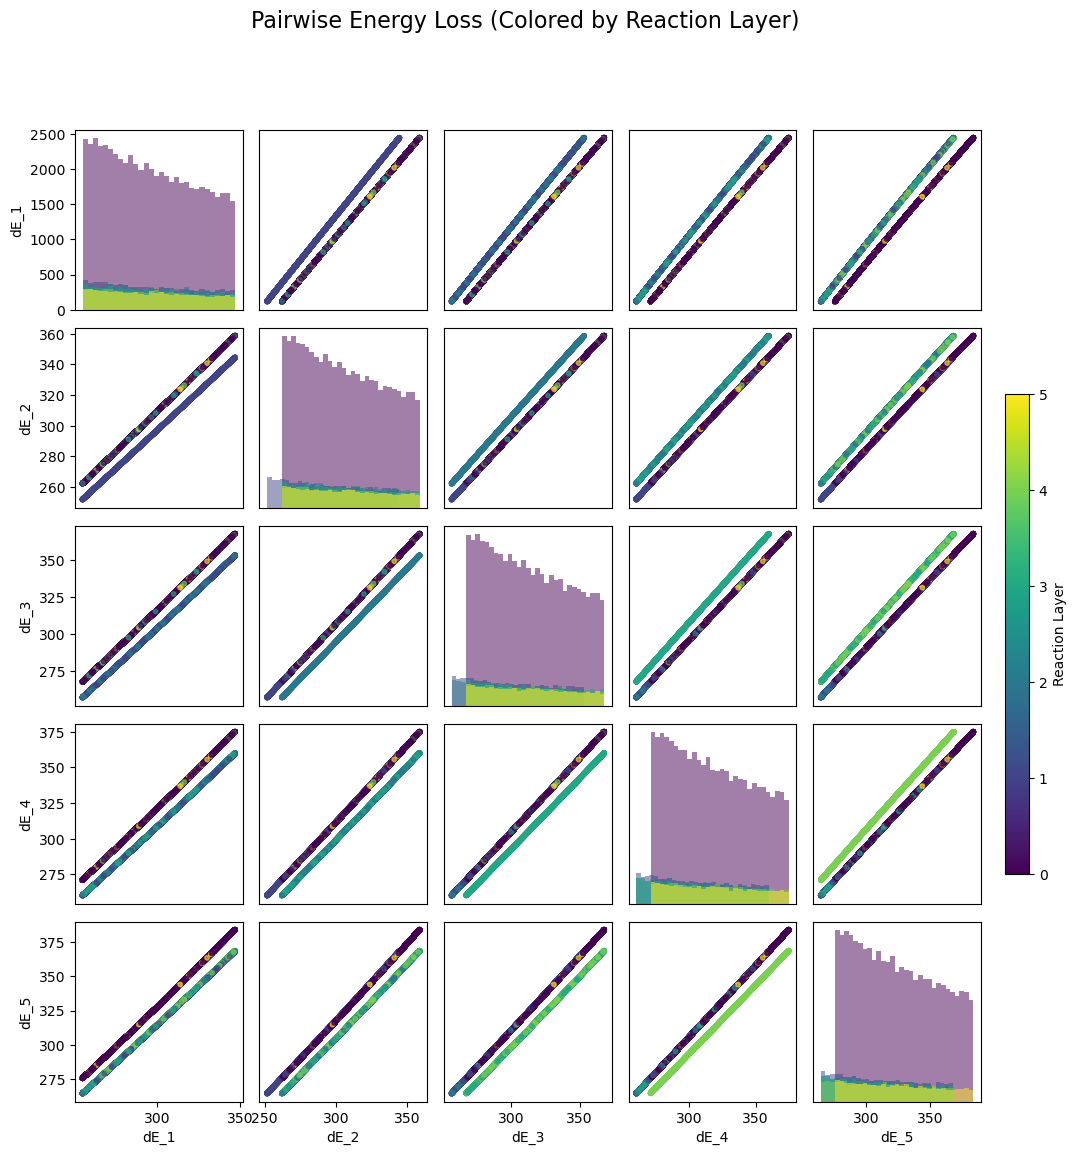

In [16]:
from pandas.plotting import scatter_matrix

from itertools import combinations
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cols = [f'dE_{i+1}' for i in range(sim_cfg["layers"])]
num_vars = len(cols)

# Normalize reaction_layer to colormap
norm = Normalize(vmin=df["reaction_layer"].min(), vmax=df["reaction_layer"].max())
cmap = plt.cm.viridis
reaction_layer_values = df["reaction_layer"]
colors = cmap(norm(reaction_layer_values))

fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
fig.suptitle("Pairwise Energy Loss (Colored by Reaction Layer)", fontsize=16, y=1.02)

for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]
        ax.grid(False)

        if i == j:
            # Diagonal: color-coded histograms
            for layer_val in sorted(df["reaction_layer"].unique()):
                subset = df[df["reaction_layer"] == layer_val][cols[i]]
                ax.hist(subset, bins=30, alpha=0.5,
                        color=cmap(norm(layer_val)), label=f"Layer {layer_val}")
        else:
            ax.scatter(df[cols[j]], df[cols[i]], c=colors, s=10, alpha=0.6)

        if i == num_vars - 1:
            ax.set_xlabel(cols[j])
        else:
            ax.set_xticks([])

        if j == 0:
            ax.set_ylabel(cols[i])
        else:
            ax.set_yticks([])

# Adjust plot to fit colorbar on the right
fig.subplots_adjust(top=0.92, wspace=0.1, hspace=0.1, right=0.88)

# Add external colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar_ax = fig.add_axes([0.9, 0.3, 0.02, 0.4])
cbar_ax.grid(False)  
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Reaction Layer")

plt.show()

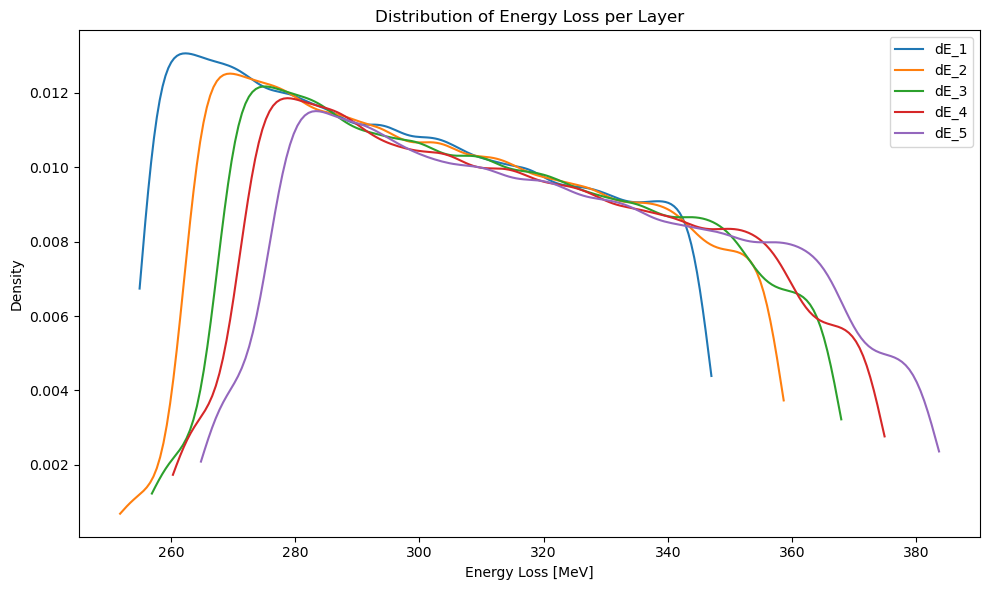

In [17]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))

for layer in range(sim_cfg["layers"]):
    col = f'dE_{layer+1}'
    
    if col not in df.columns:
        print(f"Skipping {col}: not found")
        continue

    data = df[col].dropna().astype(float).to_numpy()

    if len(np.unique(data)) < 2:
        print(f"Skipping {col}: not enough variation")
        continue

    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 200)
    plt.plot(x_vals, kde(x_vals), label=col)

plt.title("Distribution of Energy Loss per Layer")
plt.xlabel("Energy Loss [MeV]")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
